In [1]:
import shap
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from pdpbox import pdp
import numpy as np
from scipy.stats import randint, uniform

from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    f1_score,
)
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
path = "https://raw.githubusercontent.com/nogibjj/IDS705_FinalProject_Lemur_Team/main/01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
param_dist = {
    "n_estimators": list(range(50, 3001, 100)),  # default 100
    "max_depth": list(range(10, 150, 10)),  # default None
    "learning_rate": np.logspace(-4, -1, 20),  # default 0.1
    "subsample": np.linspace(0.5, 1.0, 20).tolist(),  # default 1.0
    "colsample_bytree": np.arange(0.5, 1.0, 0.2).tolist(),  # default 1.0
    "reg_alpha": np.logspace(-3, 2, 20),  # default 0
    "reg_lambda": np.logspace(-3, 2, 20),  # default 0
    "gamma": np.logspace(-4, 0, 5),  # default 0
    "min_child_weight": [3, 4, 5, 6, 7, 8, 9, 10],  # default 1
}

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="auc", random_state=42
)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring="roc_auc",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

{'subsample': 1.0,
 'reg_lambda': 2.636650898730358,
 'reg_alpha': 1.438449888287663,
 'n_estimators': 950,
 'min_child_weight': 7,
 'max_depth': 110,
 'learning_rate': 0.011288378916846883,
 'gamma': 1.0,
 'colsample_bytree': 0.5}

In [25]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Max F1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
max_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]

print(f"Max F1: {max_f1:.3f} at threshold {max_threshold:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Max F1: 0.733 at threshold 0.391
AUC - ROC: 0.927
AUC - PR: 0.827
Accuracy: 0.872


In [20]:
# Result for AUC PR curves
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/xgboost_prob.csv")

### SHAP

In [6]:
def f(x):
    return best_model.predict_proba(x)[:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [04:15, 36.88it/s]                          


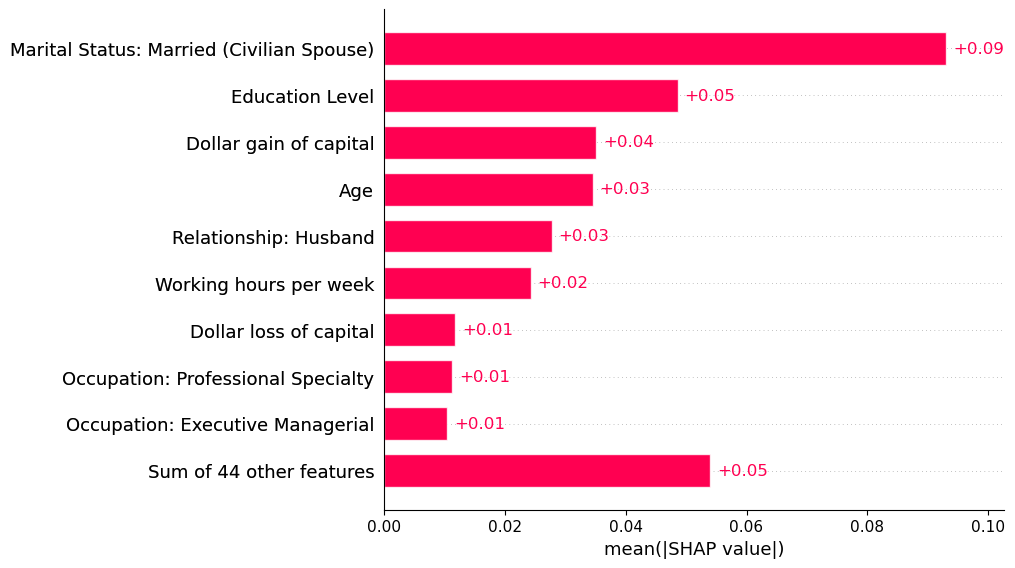

In [7]:
shap.plots.bar(shap_values)

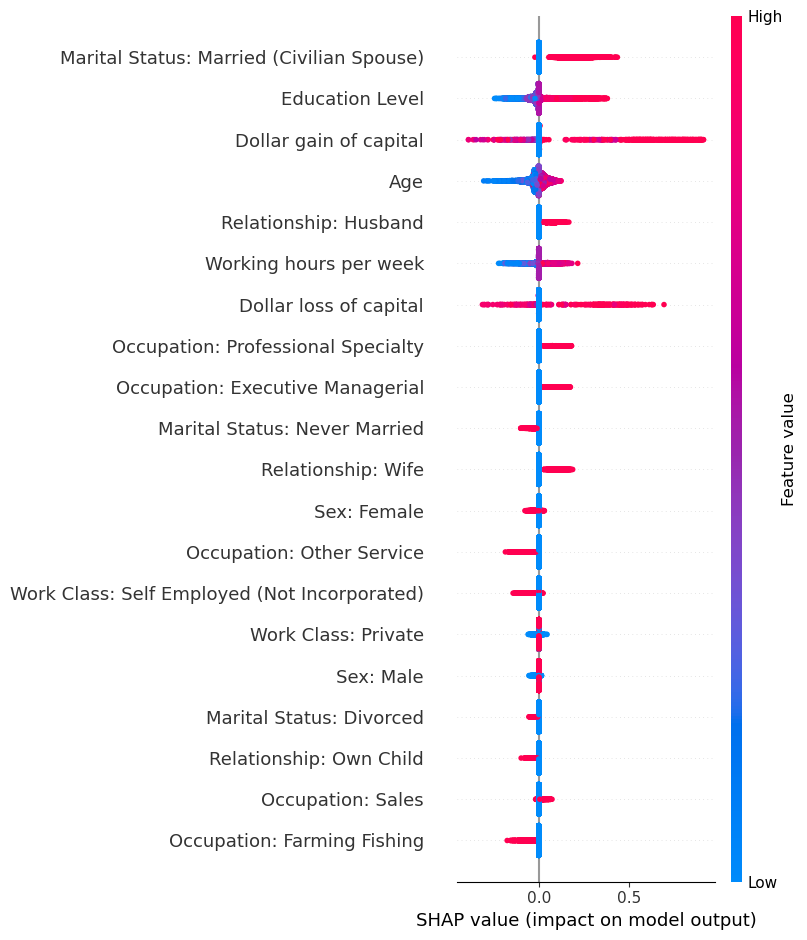

In [8]:
shap.summary_plot(shap_values, X_test)

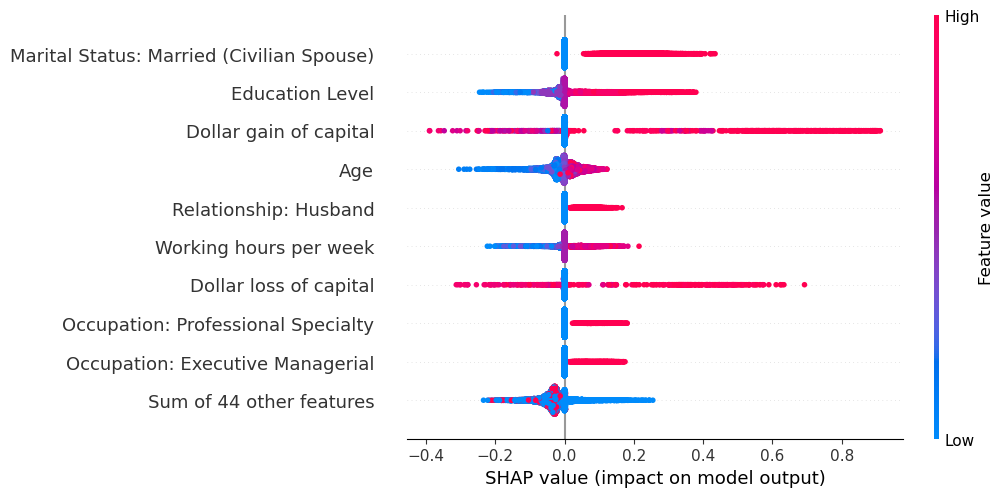

In [9]:
shap.plots.beeswarm(shap_values)

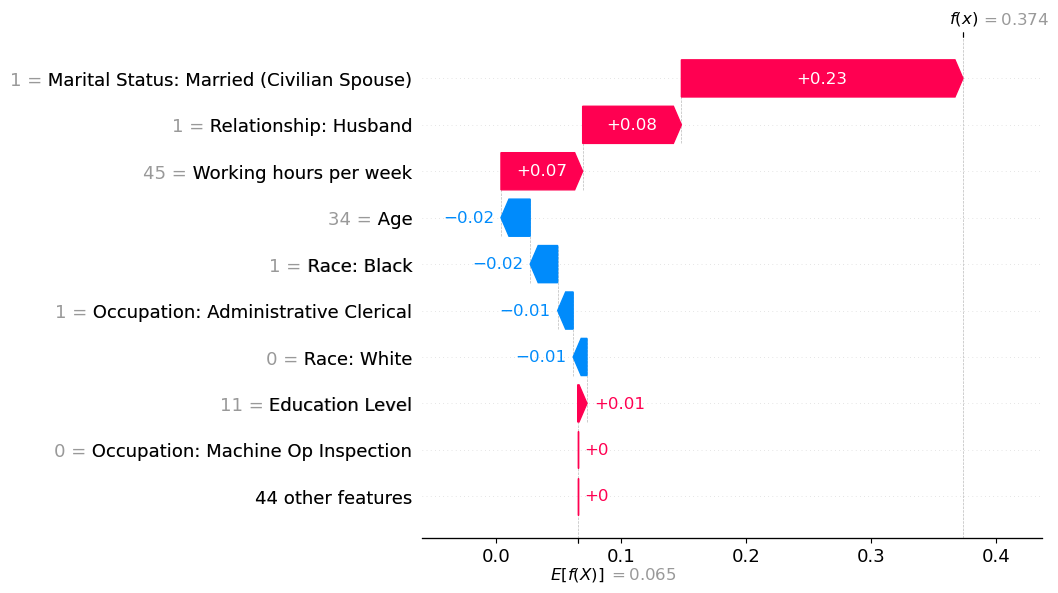

In [10]:
shap.plots.waterfall(shap_values[11])

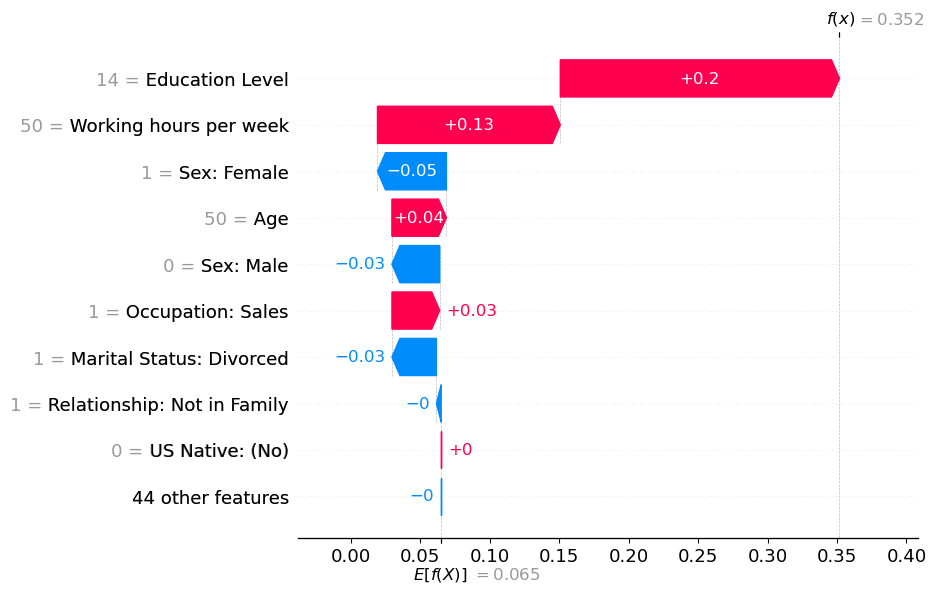

In [11]:
shap.plots.waterfall(shap_values[1000])

### Partial Dependecy Plots

In [12]:
# X_train.pop("x")

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

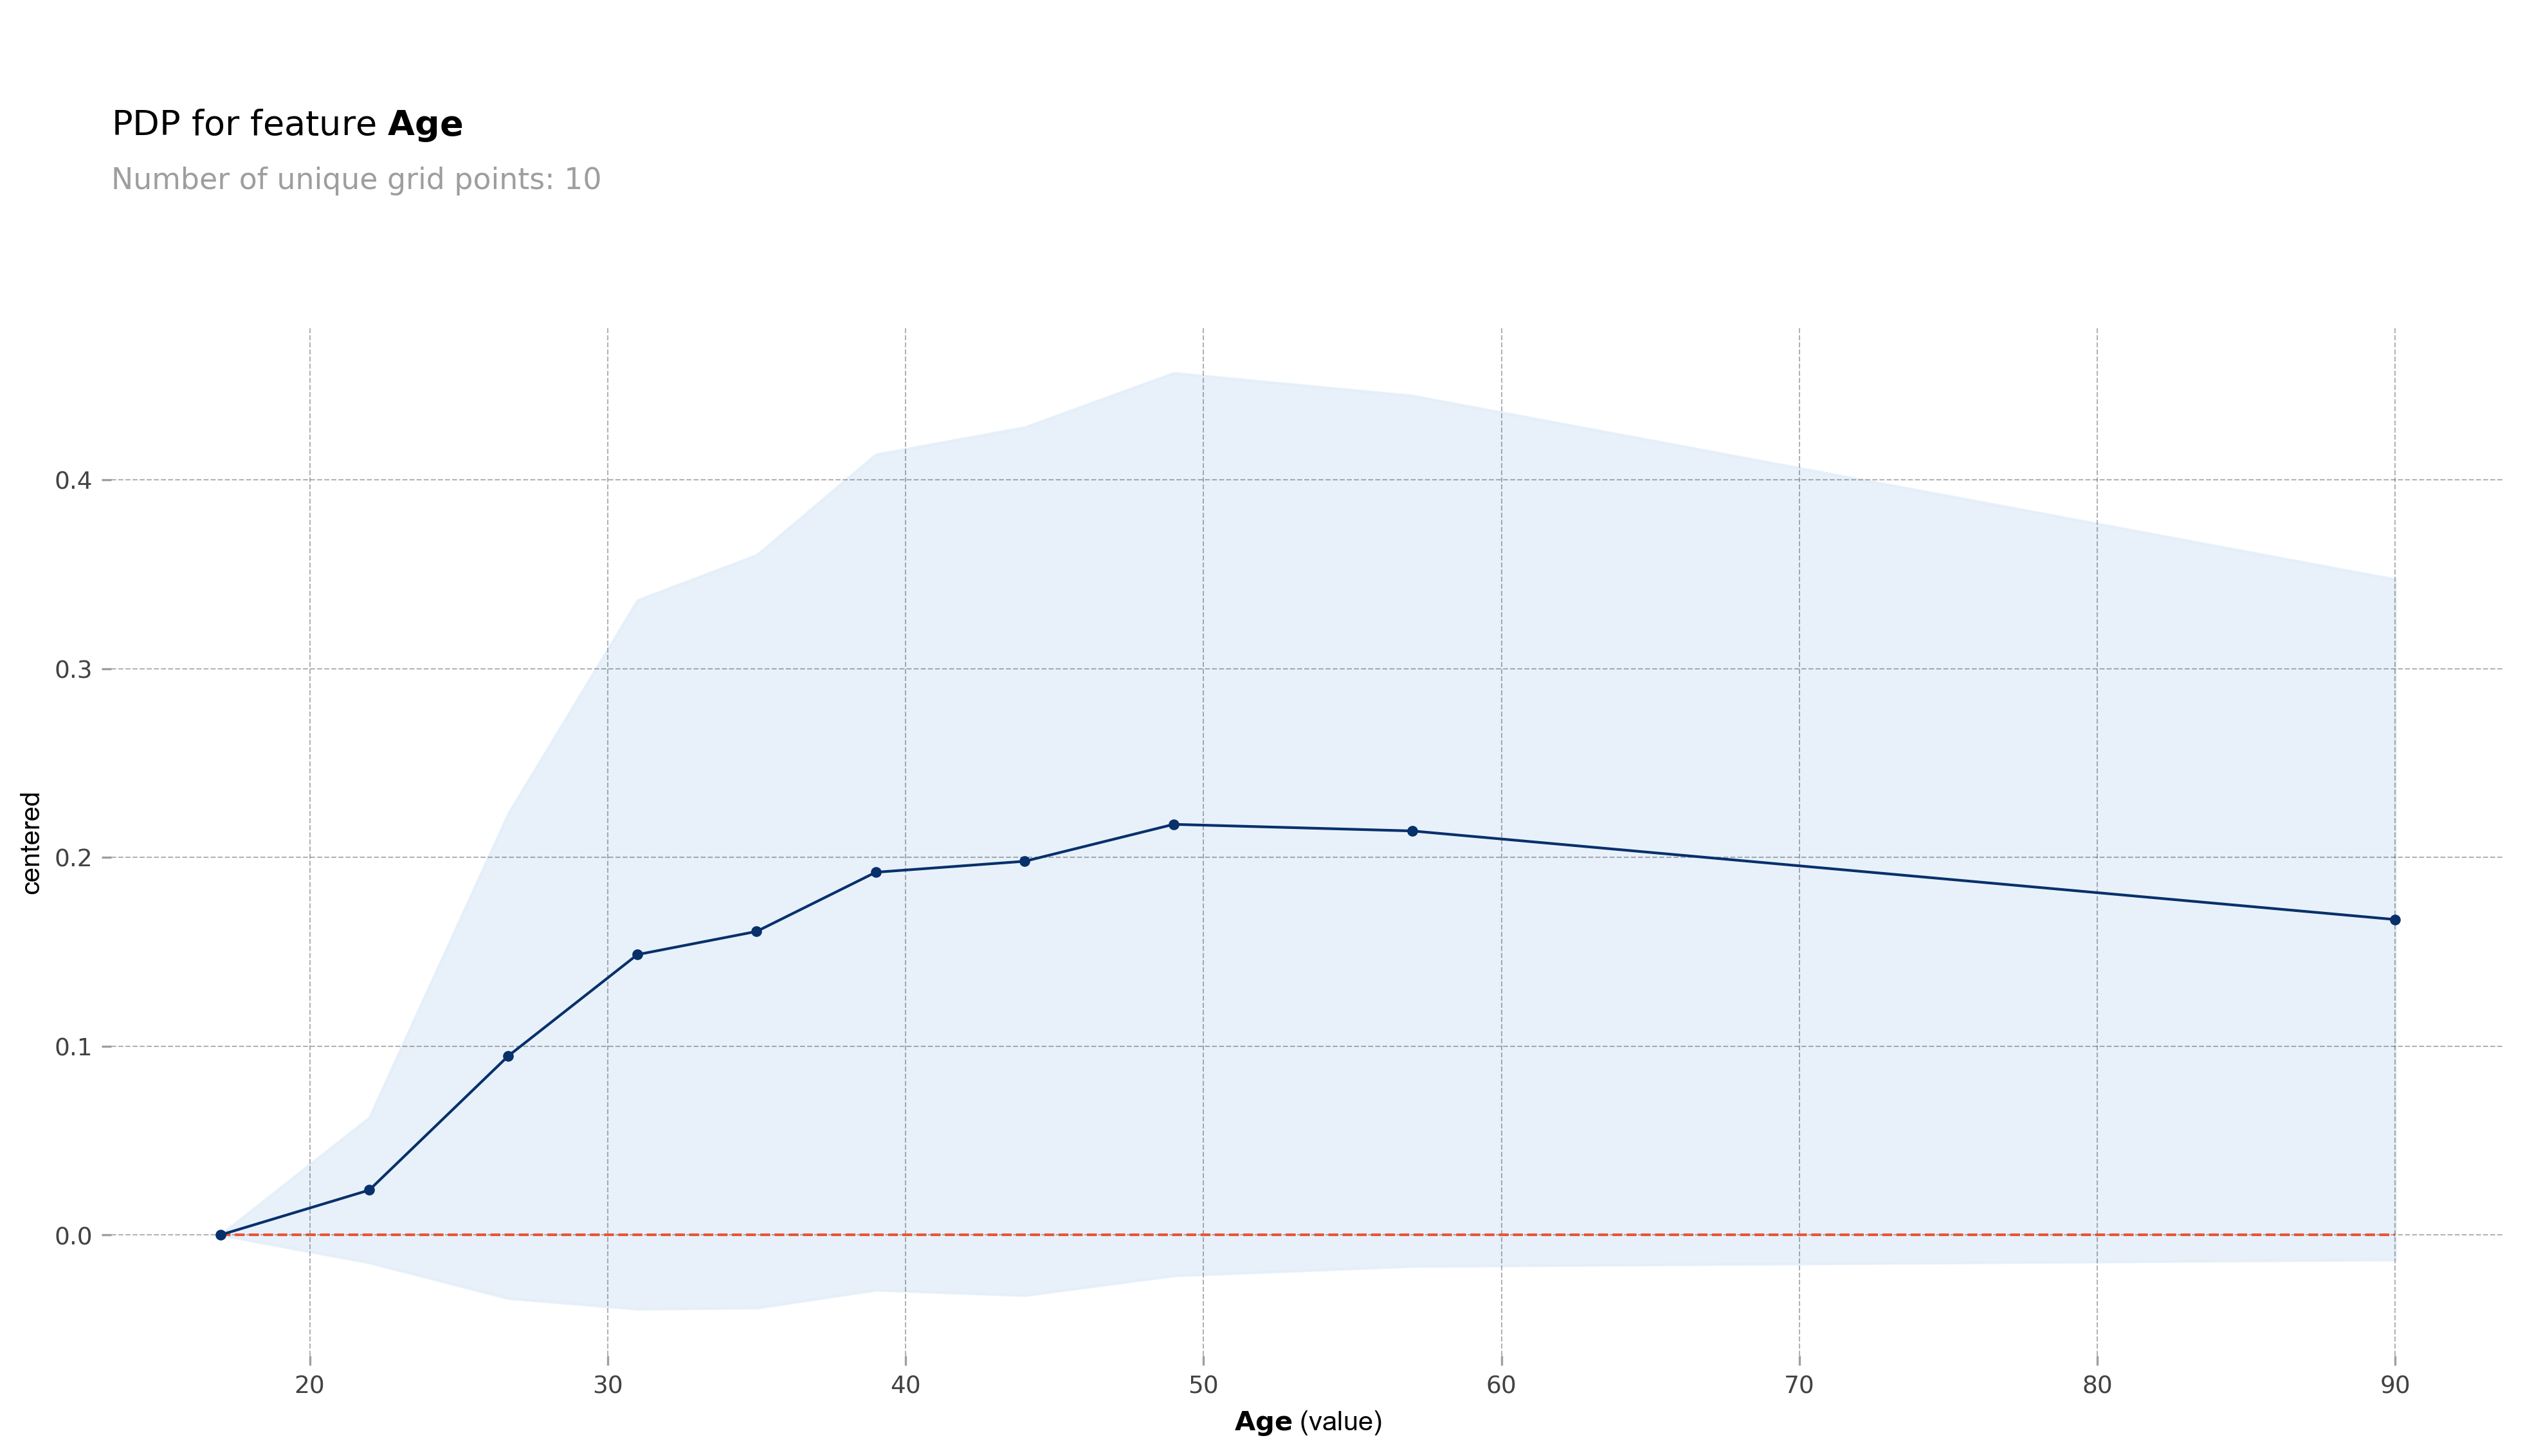

In [13]:
# X_train.pop("x")
X_train_copy = X_train.copy()

pdp_age = pdp.PDPIsolate(
    model=best_model,
    df=X_train_copy,
    model_features=X_train_copy.columns,
    feature="Age",
    feature_name="Age",
    n_classes=2,
)

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

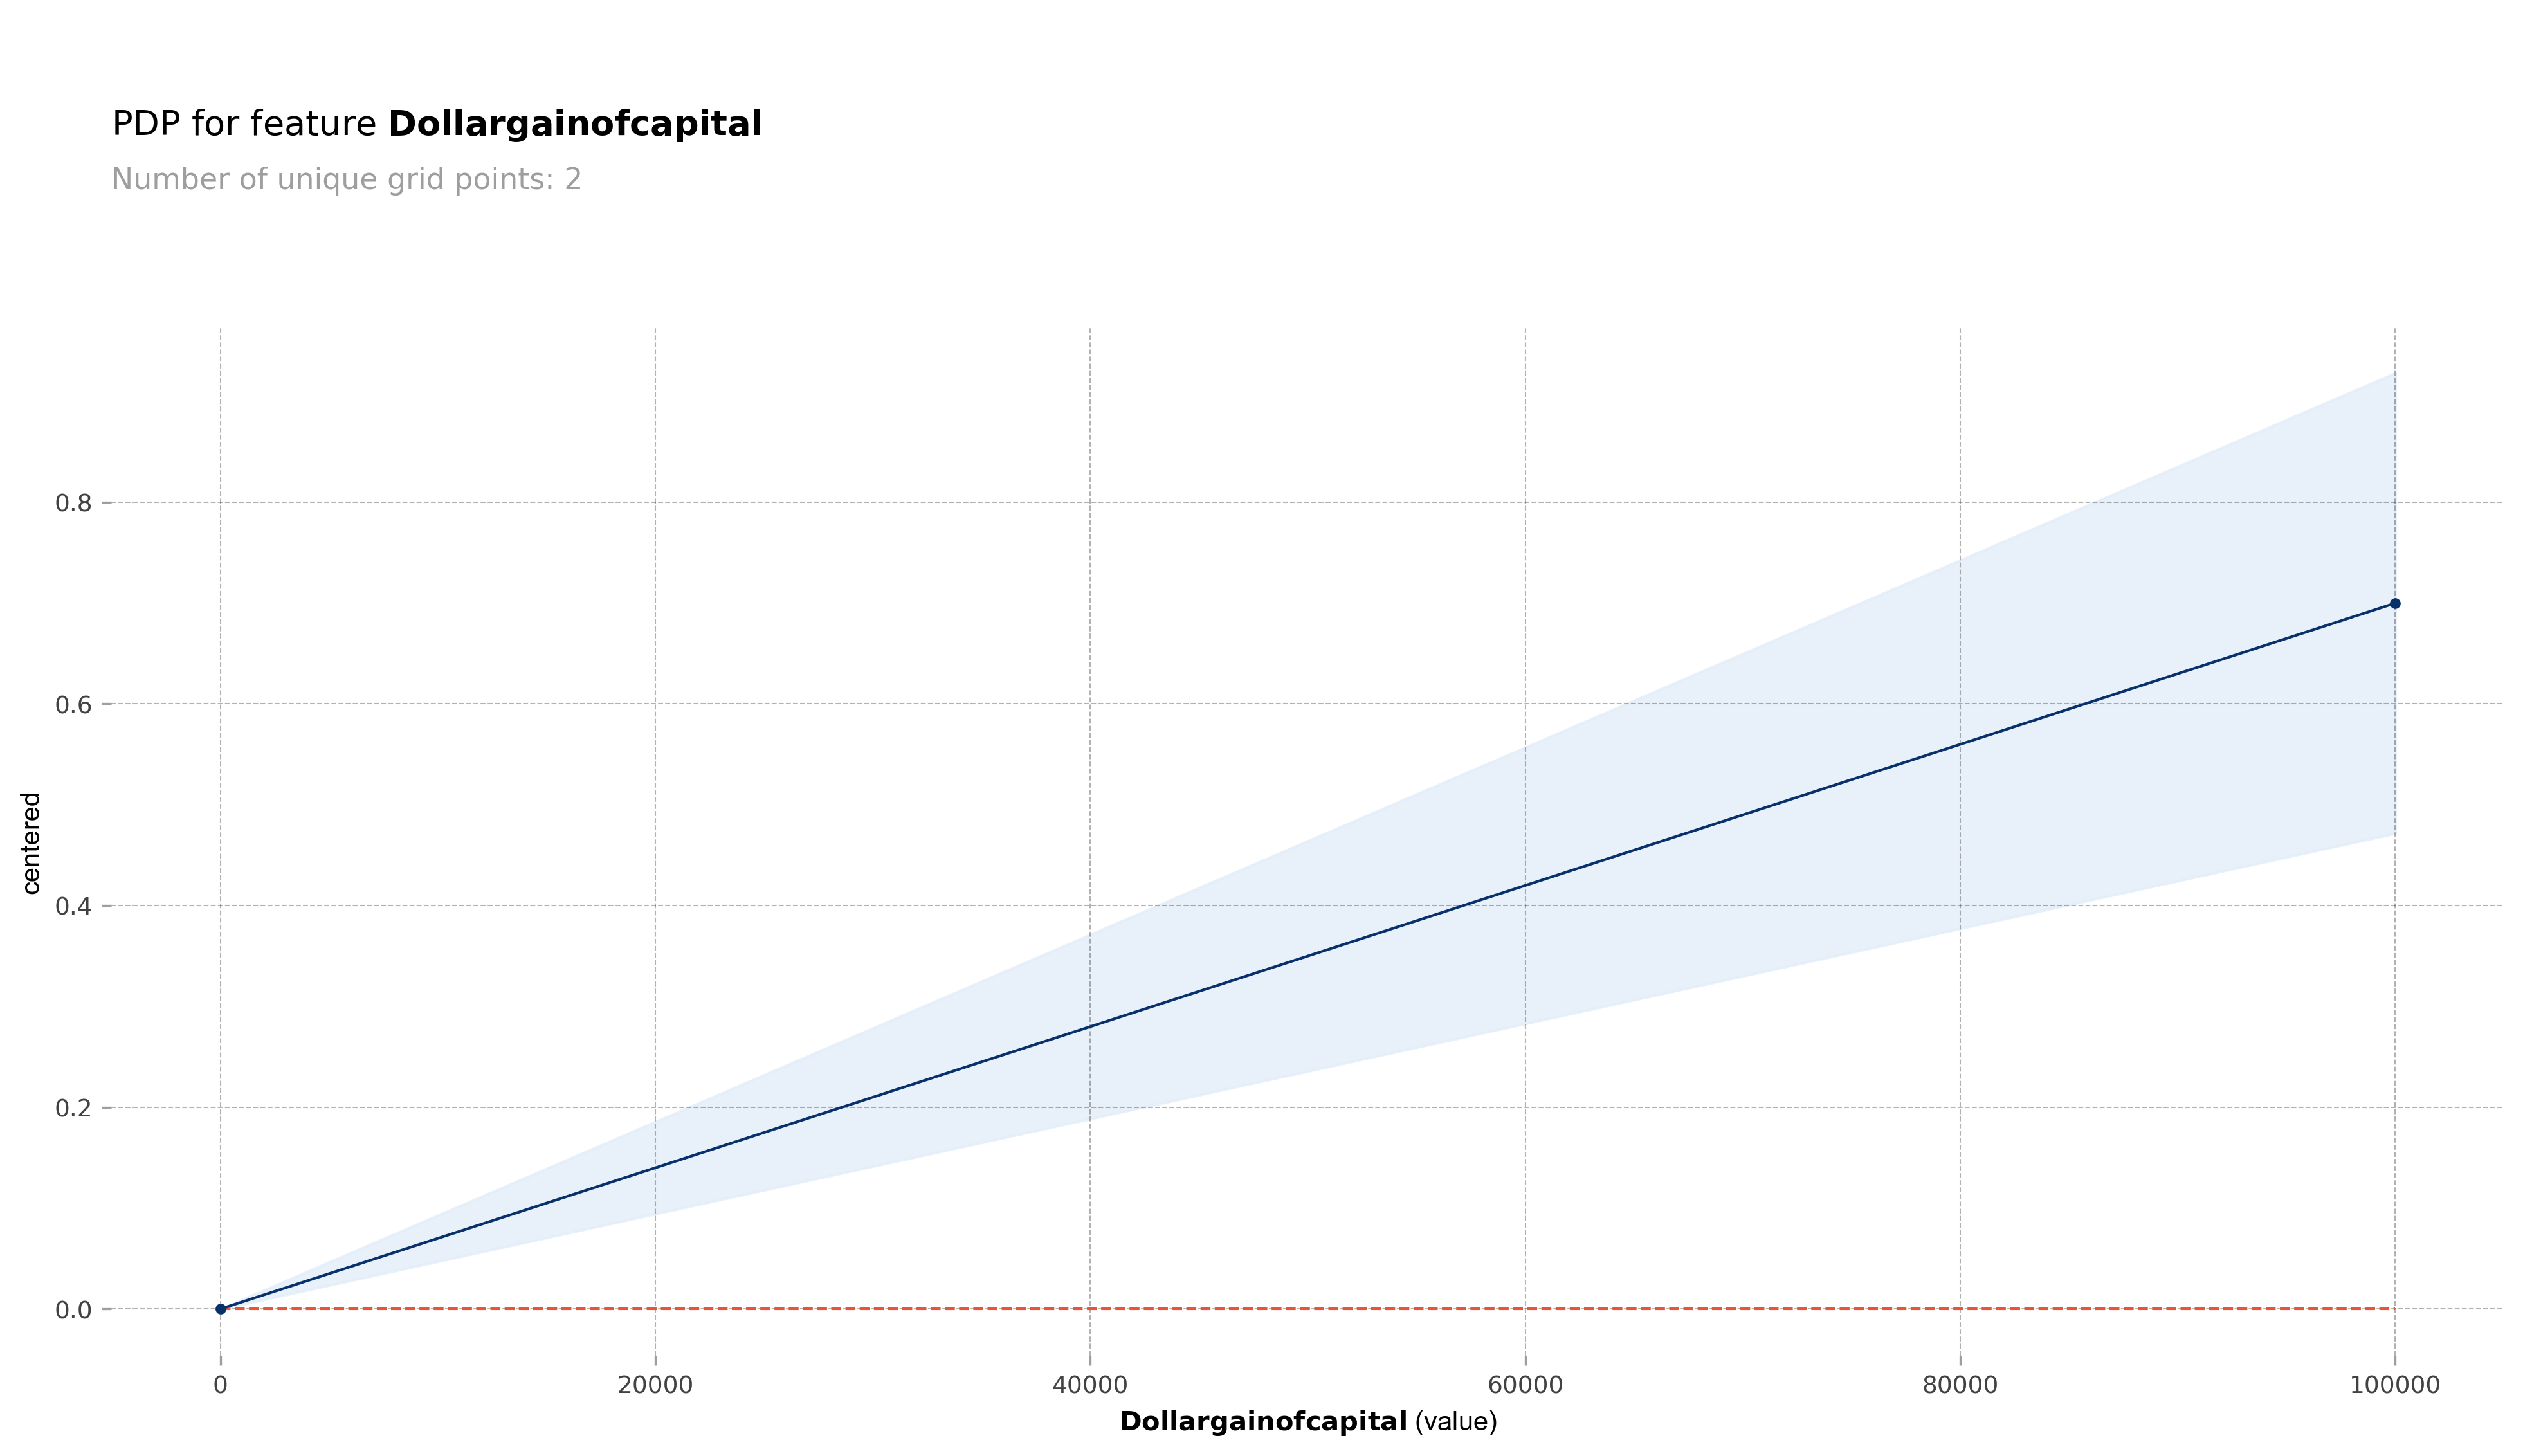

In [16]:
X_train_copy = X_train.copy()

pdp_age = pdp.PDPIsolate(
    model=best_model,
    df=X_train_copy,
    model_features=X_train_copy.columns,
    feature="Dollar gain of capital",
    feature_name="Dollar gain of capital",
    n_classes=2,
)

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

In [ ]:
X_train_copy = X_train.copy()

pdp_age = pdp.PDPIsolate(
    model=best_model,
    df=X_train_copy,
    model_features=X_train_copy.columns,
    feature="education-num",
    feature_name="education-num",
    n_classes=2,
)

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

In [ ]:
marrige_columns = [col for col in X_train.columns if col.startswith("marital-status_")]

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

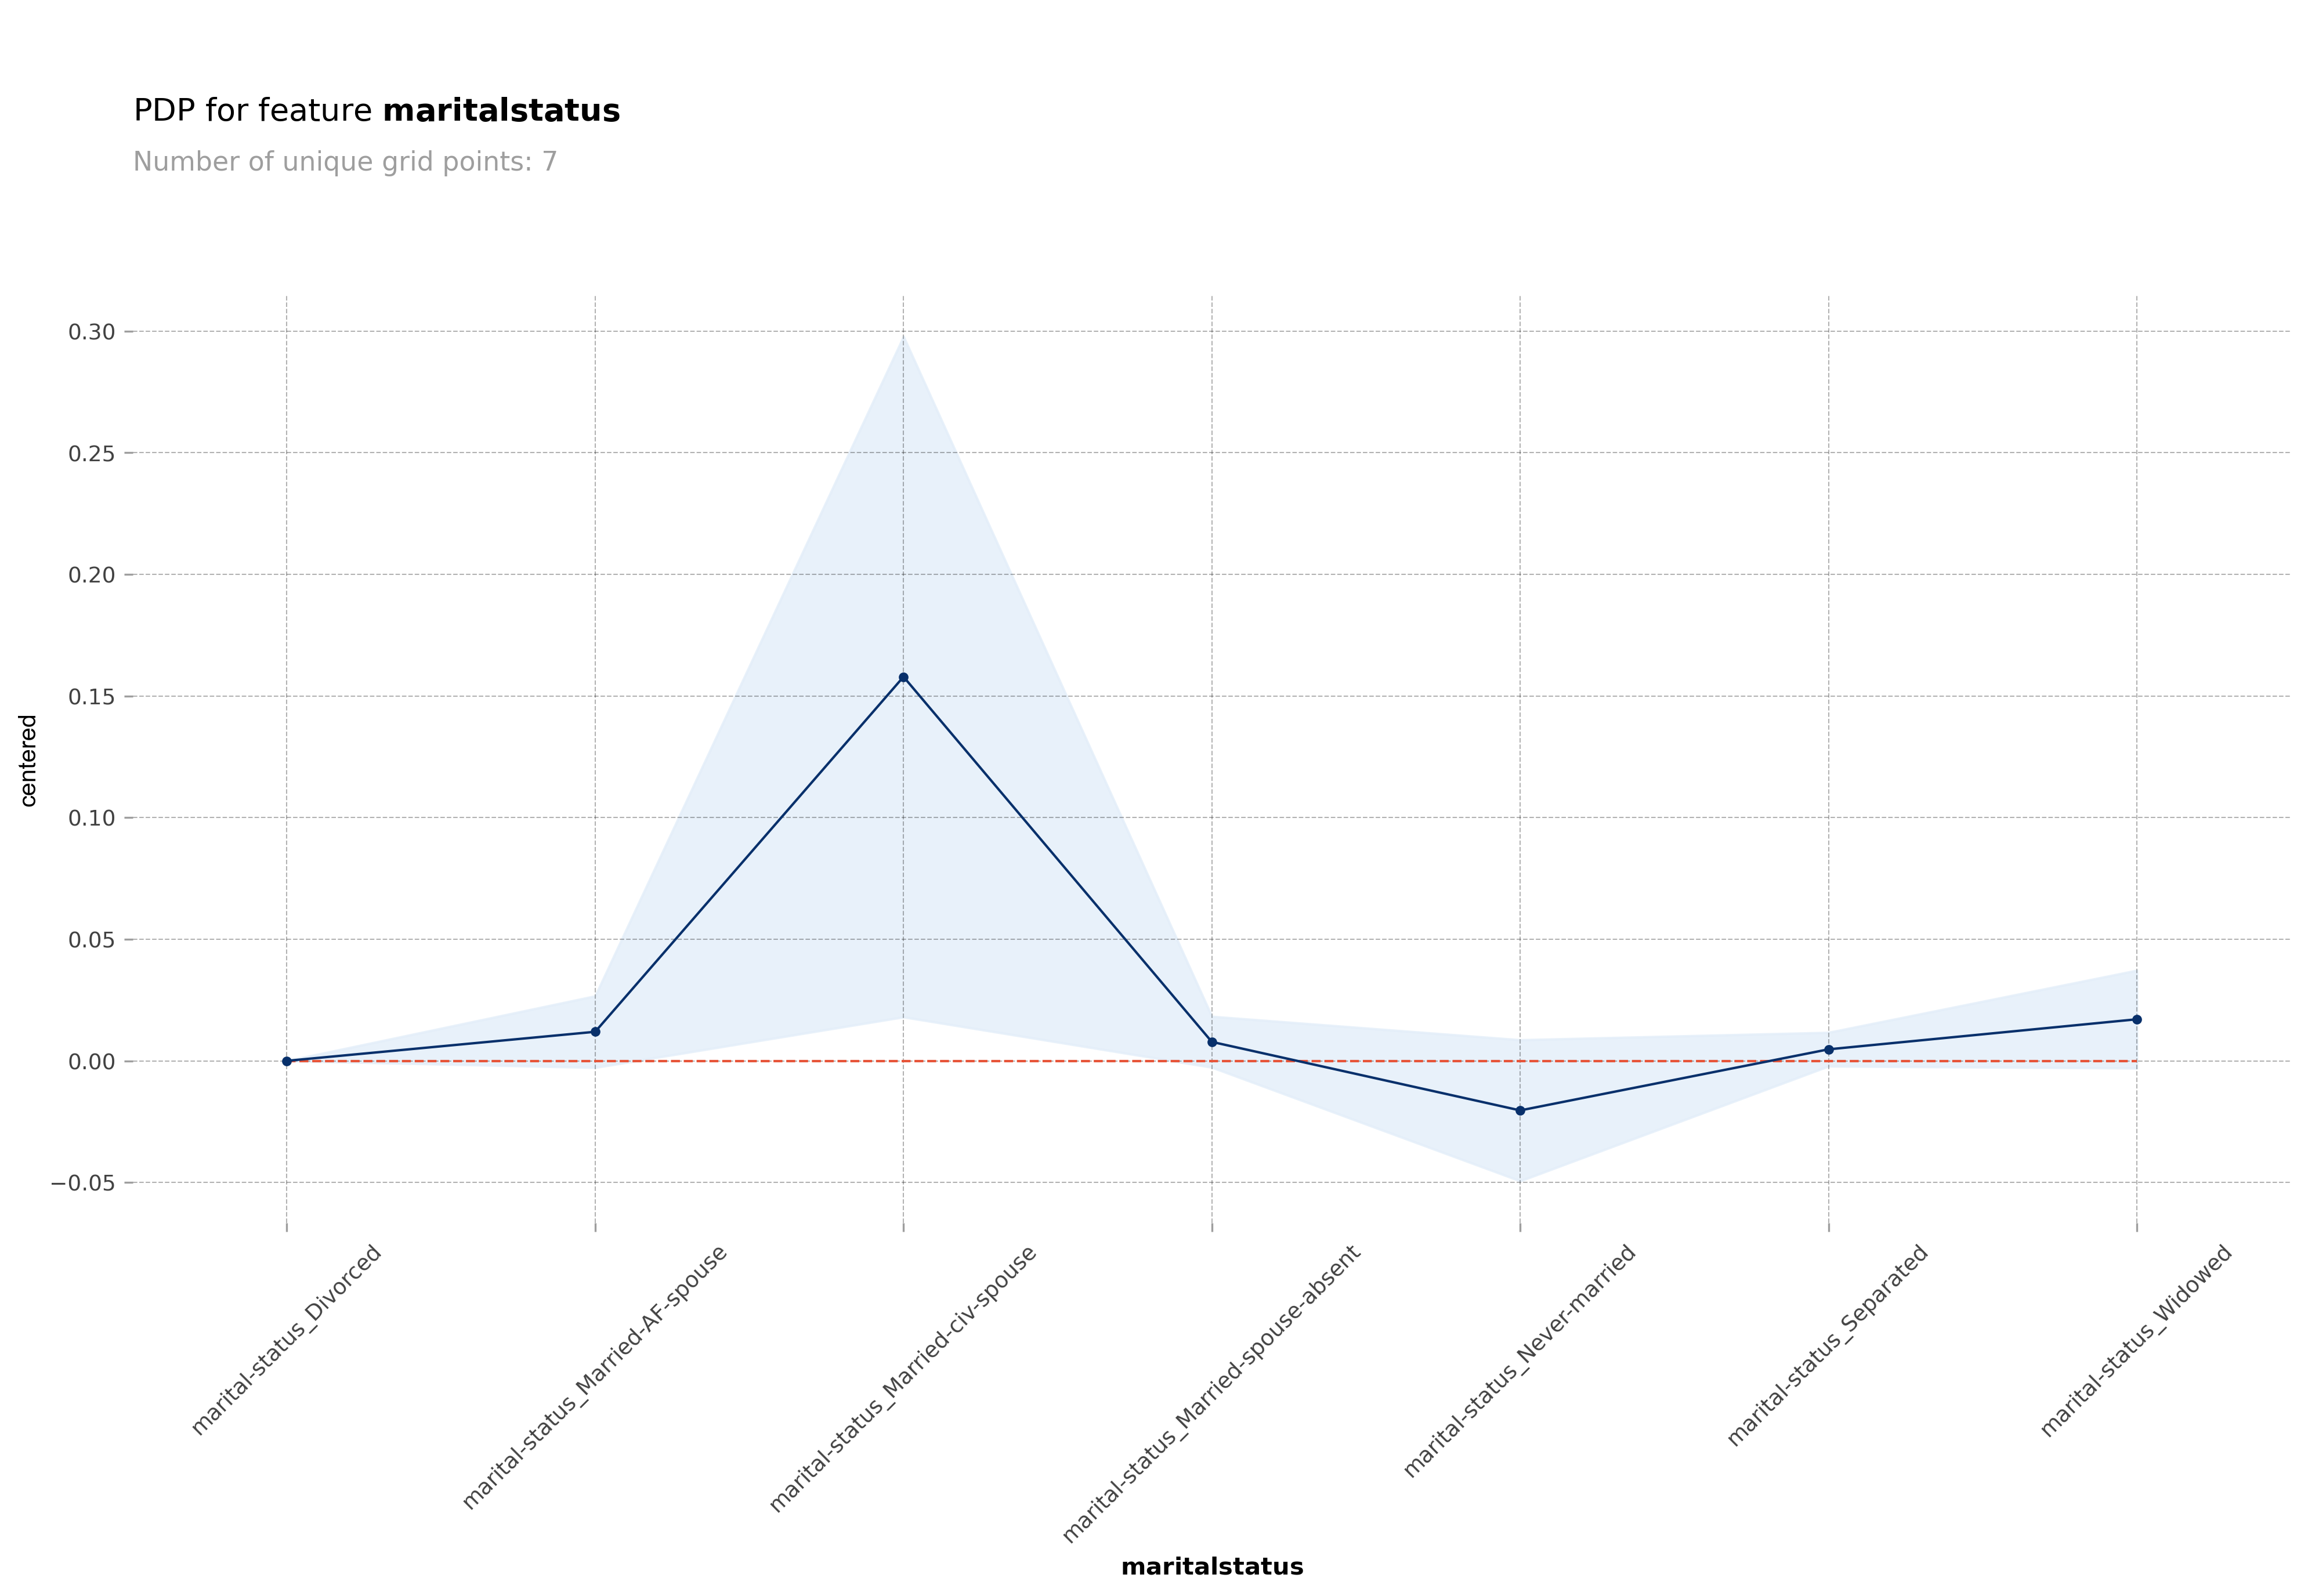

In [ ]:
# categorical feature
X_full_copy = X_train.copy()

pdp_married = pdp.PDPIsolate(
    model=best_model,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=marrige_columns,
    feature_name="marital status",
    # data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_married.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

# Show the plot
plt.show()